In [ ]:
# First, check PyTorch version
import torch
torch_version = torch.__version__

# Then install the appropriate PyTorch Geometric version
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch_version}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch_version}.html
!pip install torch-geometric
!pip install -Uqq ipdb

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html


Processing...
Done!


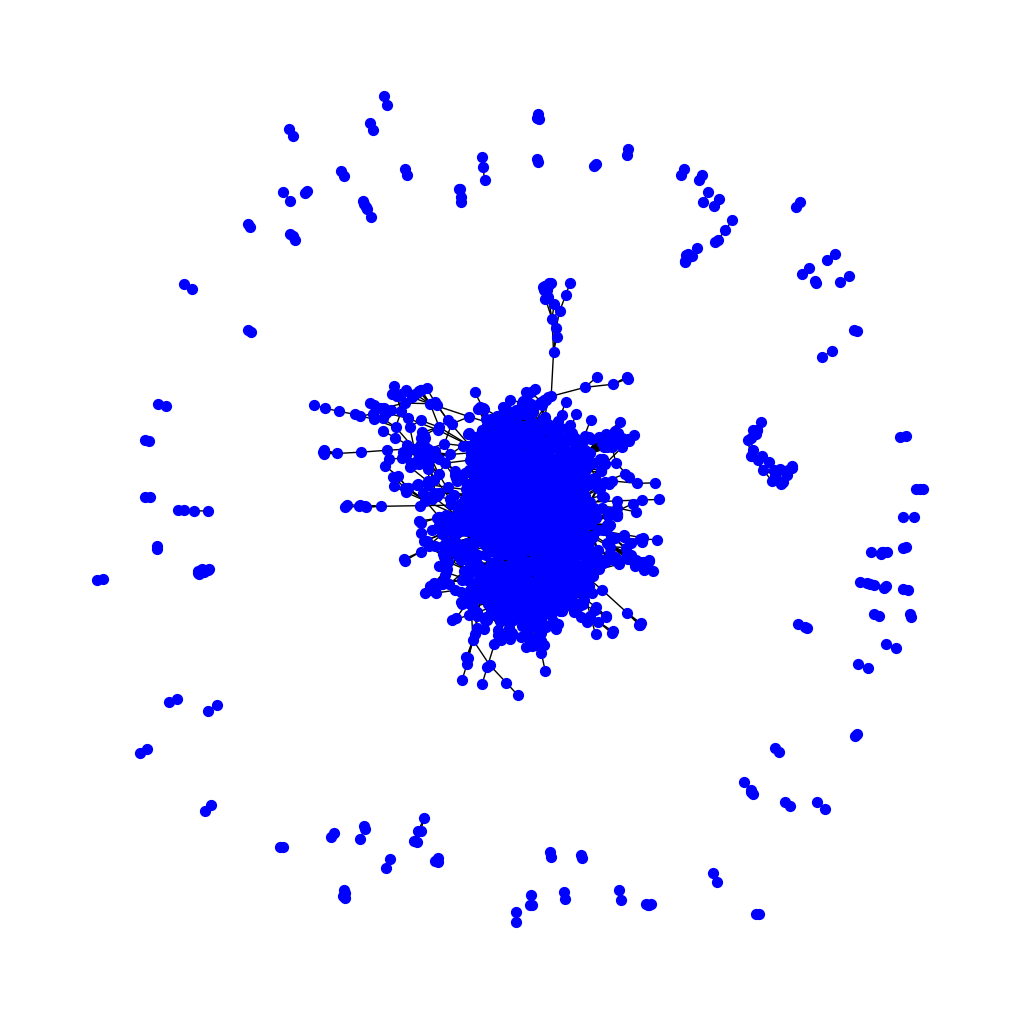

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import torch_geometric
from torch_geometric.datasets import Planetoid

# Load dataset into memory

graph = Planetoid(root='/tmp/CORA', name='CORA')[0]

G = to_networkx(graph, to_undirected=True)

In [ ]:
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
from torch import nn
import torch.nn.functional as F
import torch
import ipdb

## Build GNN with message passing

class MessagePassingGNN(nn.Module):
  def __init__(self):
    super(MessagePassingGNN, self).__init__()
    self.linear1 = nn.Linear(1433, 100)
    self.linear2 = nn.Linear(100, 50)
    self.linear3 = nn.Linear(50,50)
    self.linear4 = nn.Linear(50, 7)

  def message_pass(self, nodes_feat, edge_index, linear_pooling, linear_layer):
    num_nodes = nodes_feat.shape[0]
    output = []
    for i in range(num_nodes):
      neighbors_indexes = edge_index[1][edge_index[0] == i] # This is a directed graph of paper citations. We want to get all papers cited by this node
      neighbor_and_node_indexes = torch.cat((neighbors_indexes,torch.tensor([i])))
      aggregation = torch.sum(nodes_feat[neighbor_and_node_indexes], dim=0)
      result = F.relu(linear_pooling(aggregation))
      output.append(result)
    layer_result = torch.stack(output, dim=0)
    layer2_result = F.relu(linear_layer(layer_result))
    return layer2_result

  def forward(self, graph):
    output = []
    layer_result = torch.tensor([])
    num_nodes = graph.x.shape[0]
    result = self.message_pass(graph.x, graph.edge_index, self.linear1, self.linear2)
    result = self.message_pass(result, graph.edge_index, self.linear3, self.linear3)
    prediction = F.softmax(result)
    return prediction

In [ ]:
from torch.optim import Adam

EPOCHS = 100
LR = 0.001

model = MessagePassingGNN()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), LR)


for i in range(EPOCHS):
  optimizer.zero_grad()
  predictions = model(graph)
  result = criterion(predictions[graph.train_mask], graph.y[graph.train_mask])
  result.backward()
  print(result.item())
  optimizer.step()

<ipython-input-64-86d560b3d377>:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prediction = F.softmax(result)


3.912508249282837
3.9102182388305664
3.9069554805755615
3.900895833969116
3.8916473388671875
3.8805131912231445
3.8652706146240234
3.844956636428833
3.8175721168518066
3.7860991954803467
